
## 1 ▸ Setup & model selection

First, we load the demo environment, where we choose one of four pretrained ImageNet classifiers _(ResNet-50, ResNet-101, VGG-16, or ViT)_ on which to run the attack.

In our hard-label threat model we only observe the top-1 prediction label of the classifier. We query

$\hat y(x)=\arg_x\max_k[f(x)]_k.$

**We will now**

* install / import the dependencies listed in the paper (torch, timm, pillow…);

* set the random seed for reproducibility;

* pick `MODEL_NAME` from `{resnet50, resnet101, vgg16, vit}`;



## 2 ▸ Inspect the source–target pair

Before we begin the attack, we shall visualize the source-target image pair chosen. We will also note the starting labels predicted by the chosen classifier, along with the $\ell^2$ distance to the source image.

> **Objective:** To minimize the $\ell^2$ distance to the source image while having the prediction match the label of the target image using as little queries as possible.

## 3 ▸ Soft-edge Mask of Target Image

Here, we visualize the output of **Algorithm 1** from the paper. We use Sobel filters to detect the edges on our target image, and soften the edges to make our perturbations spread out so we don't get stuck in a narrow decision space by making sharp changes.

## 4 ▸ Global Edge-informed Search

We now begin our attack. Here, we run **Algorithm 2** to apply global perturbations to our target image to create an adversarial image that is closer to the source image than the starting target image while still classifying the same as the target image under the chosen model. We visualize below the result of the first three perturbations, and the final result of the global edge-informed search.

## 5 ▸ Patch-based Edge-informed Search

On our adversarial image, we now implement **Algorithm 3** to apply local patch-wise perturbations. We visualize below the result of the first three perturbations, corresponding patch locations, and finally, the result of the patch-based search. With this, the TEA attack completes, and we reach the _"turning-point"_. For further refinement, we can implement any geometry-based method such as CGBA or CGBA-H.

## Appendix ▸ CGBA/CGBA-H for further refinement

Here we use the result of TEA as a starting image to run CGBA-H [1] for further refinement in case more queries are available.


Processing pair 2: 2a.JPEG -> 2b.JPEG


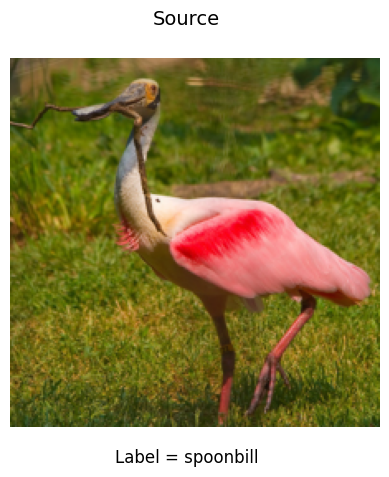

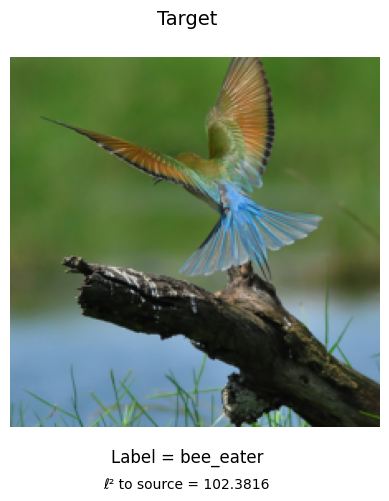

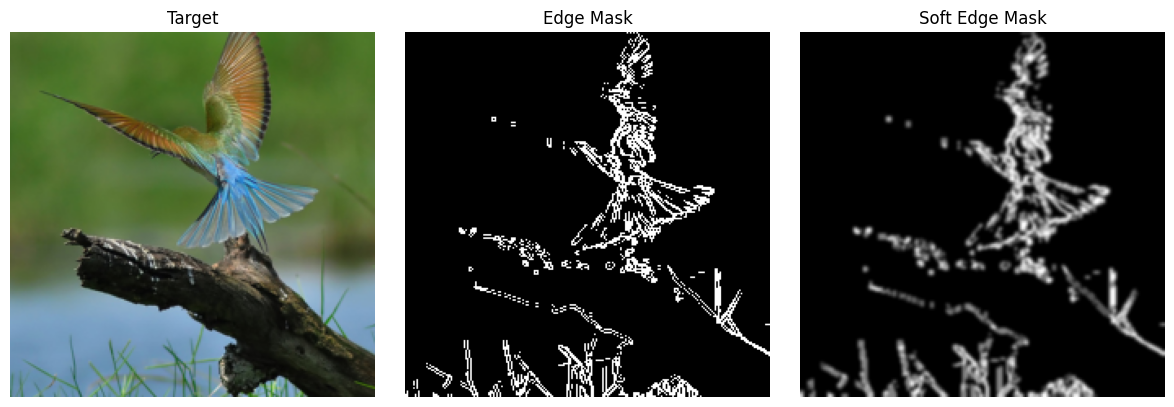

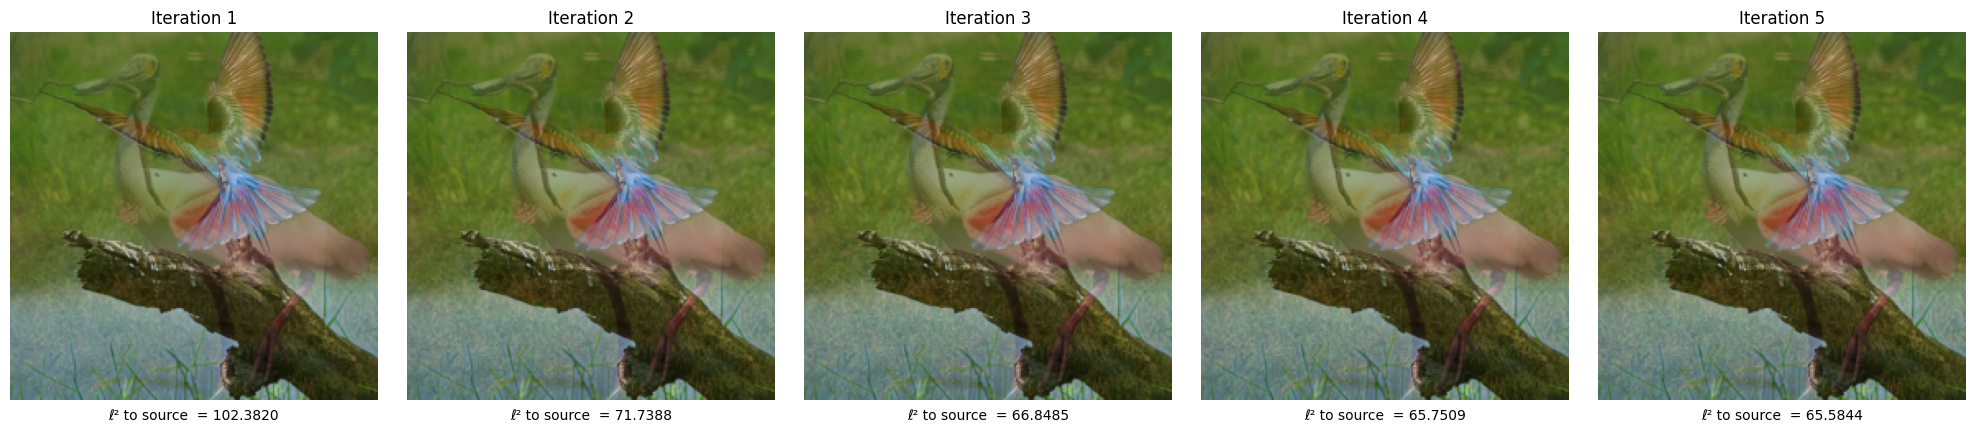

Norm after global edge-informed search is 65.58444213867188, queries after 0 rounds: 48


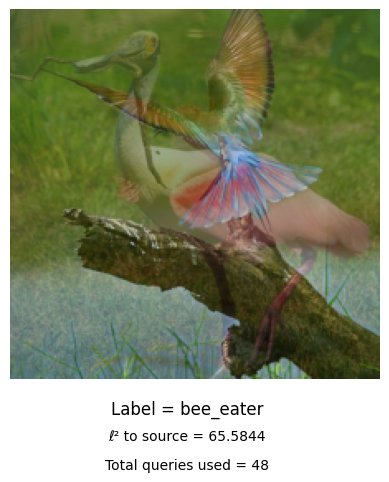

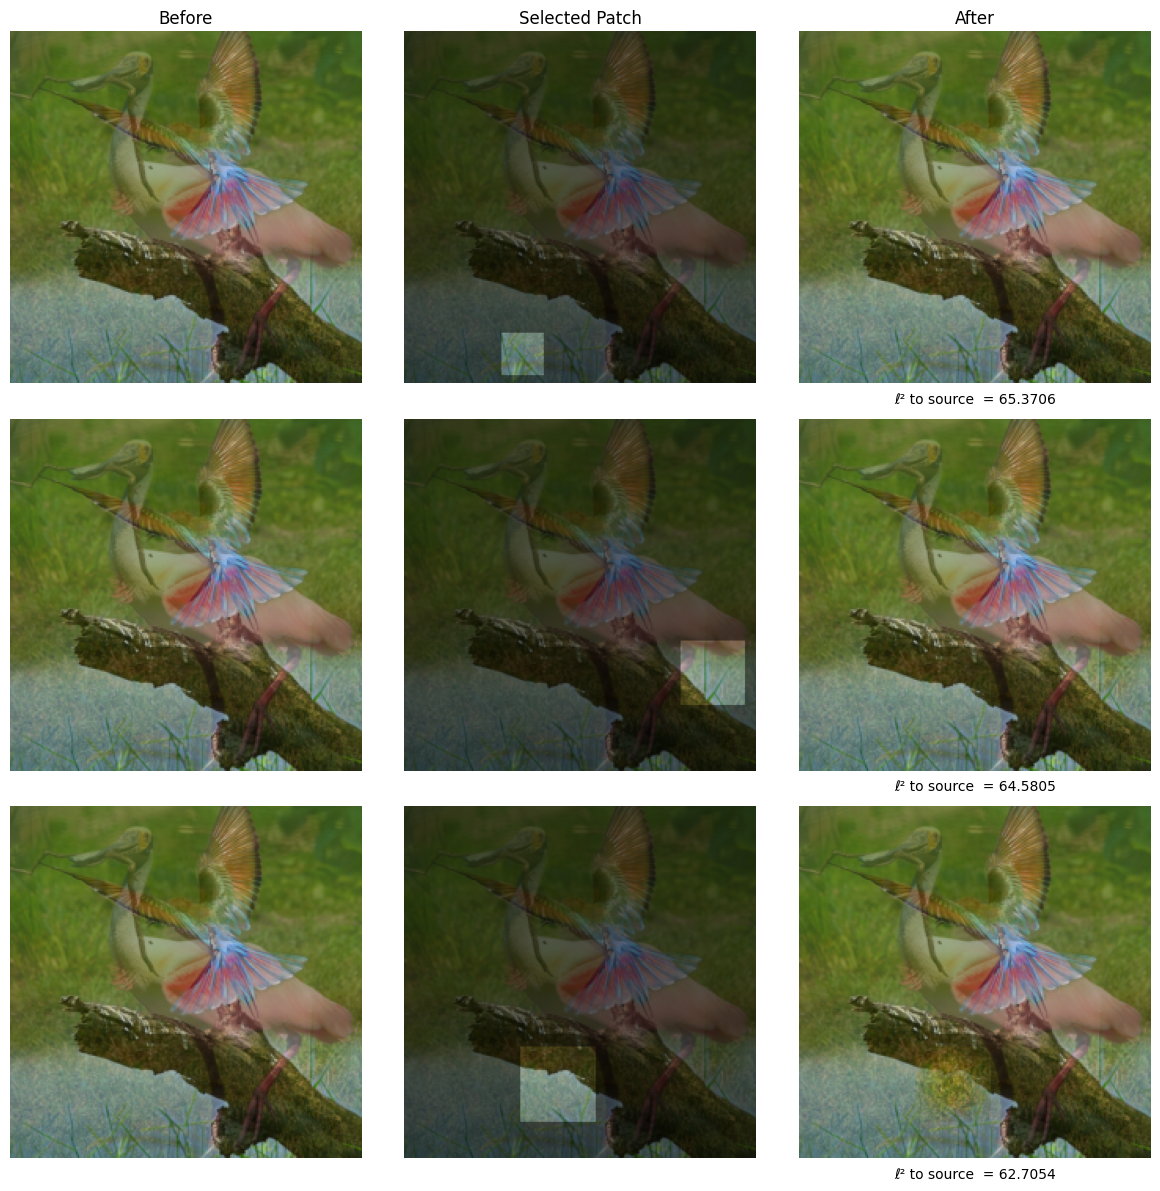

Norm after patch refinement: 46.432804107666016, queries used: 417


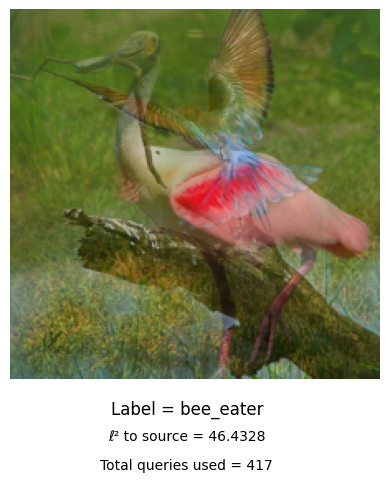

Total calls used: 417


In [5]:
import os
from TEA import (
    initialize_attack,
    edge_mask_initialization,
    global_edge_informed_search,
    patch_based_edge_informed_search,
)
from utils import (
    get_device,
    get_model_choice,
    get_transform,
    get_sorted_image_pairs,
    load_and_transform_image,
    validate_pair_id,
    get_pair_files,
)

pair_id = 2
folder = "../ILSVRC2012_val_pairs"
device = get_device()
transform = get_transform()
model_arch = get_model_choice()
files = get_sorted_image_pairs(folder)
validate_pair_id(pair_id, len(files))

file_a, file_b = get_pair_files(files, pair_id)
print(f"\nProcessing pair {pair_id}: {file_a} -> {file_b}")

image_a = load_and_transform_image(os.path.join(folder, file_a), transform)
image_b = load_and_transform_image(os.path.join(folder, file_b), transform)

initialization = initialize_attack(pair_id, image_a, image_b, model_arch=model_arch)

soft_edge_mask = edge_mask_initialization(*initialization[1:5])

global_result = global_edge_informed_search(soft_edge_mask, *initialization, iterations_to_show=5)

x_adv, total_calls = patch_based_edge_informed_search(*global_result,model_arch=model_arch,file_a=file_a,file_b=file_b,iterations_to_show=3)